In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='1'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import torch
import logging
import time
from argparse import ArgumentParser

import cv2
import json_tricks as json
import numpy as np

from multi_camera.datajoint.sessions import Subject, Session, Recording
from multi_camera.analysis.calibration import plot_cal

from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video
from multi_camera.datajoint.multi_camera_dj import Calibration,PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod
from multi_camera.datajoint.sessions import Recording
from hand_detection.hand_dj import HandPoseReconstructionMethodLookup,HandPoseReconstructionMethod, HandPoseReconstruction,HandPoseEstimationMethodLookup
from hand_detection.hand_dj import HandBbox,HandBboxMethod, HandPoseEstimation,HandPoseEstimationMethod,HandPoseEstimationVideo,MJXReconstruction
from hand_detection.hand_dj import MJXReconstructionVideo,MJXReconstructionAnalysis

[2024-04-08 11:32:49,594][INFO]: Connecting pfirouzabadi@127.0.0.1:3306
[2024-04-08 11:32:49,688][INFO]: Connected pfirouzabadi@127.0.0.1:3306


In [4]:
Recording & f'participant_id="m003"'
# CUDA_VISIBLE_DEVICES=0 python -m multi_camera.datajoint.calibrate_cameras --checkerboard_size=29 --checkerboard_dim=3,6 /mnt/CottonLab/mobile_system_data/20240124/m003/calibration_20240124_143224

participant_id,session_date,recording_timestamps,camera_config_hash,comment
m003,2024-01-11,2024-01-11 12:22:02,9e22c563de,
m003,2024-01-11,2024-01-11 12:23:02,9e22c563de,
m003,2024-01-11,2024-01-11 12:26:33,9e22c563de,
m003,2024-01-11,2024-01-11 12:27:50,9e22c563de,
m003,2024-01-11,2024-01-11 12:28:44,9e22c563de,
m003,2024-01-11,2024-01-11 12:30:08,9e22c563de,
m003,2024-01-24,2024-01-24 14:14:11,10d8a3c714,
m003,2024-01-24,2024-01-24 14:15:32,10d8a3c714,
m003,2024-01-24,2024-01-24 14:16:22,10d8a3c714,
m003,2024-01-24,2024-01-24 14:19:48,10d8a3c714,


In [2]:
# (SingleCameraVideo & f'filename LIKE "{subject_id}_%"')
(Calibration & 'recording_base LIKE "%20240402%"')

cal_timestamp,camera_config_hash,recording_base,num_cameras,camera_names list of camera names,camera_calibration calibration results,reprojection_error,calibration_points,calibration_shape,calibration_type
2024-04-02 13:26:19,07e0d11022,calibration_20240402_132619,8,=BLOB=,=BLOB=,0.225383,=BLOB=,=BLOB=,None
2024-04-02 13:33:36,07e0d11022,calibration_20240402_133336,8,=BLOB=,=BLOB=,0.153904,=BLOB=,=BLOB=,None
2024-04-02 13:36:59,07e0d11022,calibration_20240402_133659,8,=BLOB=,=BLOB=,0.167472,=BLOB=,=BLOB=,None


In [23]:
key = (Calibration&((SingleCameraVideo & f'filename LIKE"{subject_id}%"'))).fetch('KEY')
(Calibration&((SingleCameraVideo & f'filename LIKE "{subject_id}%"')))
# (Calibration&key[-1]).delete()

cal_timestamp,camera_config_hash,recording_base,num_cameras,camera_names list of camera names,camera_calibration calibration results,reprojection_error,calibration_points,calibration_shape,calibration_type
2024-01-24 14:04:02,10d8a3c714,calibration_20240124_140402,8,=BLOB=,=BLOB=,0.11063,=BLOB=,=BLOB=,None
2024-01-24 14:09:45,10d8a3c714,calibration_20240124_140945,8,=BLOB=,=BLOB=,0.0693069,=BLOB=,=BLOB=,None
2024-01-24 14:12:00,10d8a3c714,calibration_20240124_141200,8,=BLOB=,=BLOB=,0.0953316,=BLOB=,=BLOB=,None
2024-01-24 14:32:24,10d8a3c714,calibration_20240124_143224,8,=BLOB=,=BLOB=,28.2317,=BLOB=,=BLOB=,None


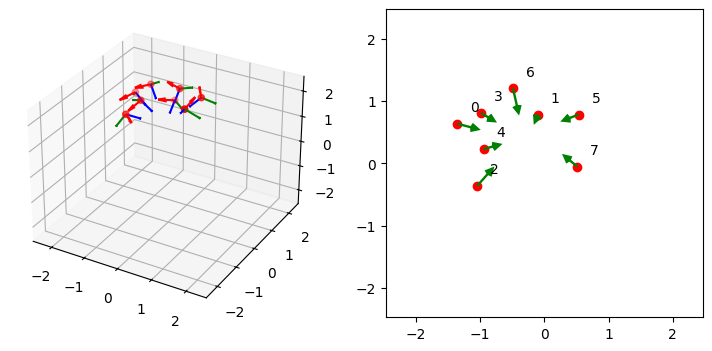

In [9]:
%matplotlib inline

subject_id = "m003"
command = (Calibration & 'recording_base LIKE "%20240402_1336%"')
# prm = (Calibration&(CalibratedRecording*Recording &f'participant_id="{subject_id}"')).fetch1('camera_calibration')
# cals = (Calibration&((SingleCameraVideo & f'filename LIKE"{subject_id}%"'))).fetch('camera_calibration')
prm = (command).fetch1('camera_calibration')
cals = (command).fetch('camera_calibration')
plot_cal(cals[0])

plt.show()

In [ ]:
# %%bash
cd ~/notebooks/mmpose/MultiCameraTracking
CUDA_VISIBLE_DEVICES=0 python -m multi_camera.datajoint.calibrate_cameras --checkerboard_size=35 --checkerboard_dim=6,5 /mnt/CottonLab/mobile_system_data/20240227/m005/calibration_20240227_152020